In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import OUT_MODEL_DIR
from utils.load import load_data, save_file
from src.dm import dm_test

In [4]:
# directory overview

In [5]:
def get_model_list(path):
    dir_list = os.listdir(OUT_MODEL_DIR)
    dir_ist = [item for item in dir_list if '.' not in item or item == "archive"]
    dir_list = [item for item in dir_list if item != "archive"]
    return dir_list

In [6]:
get_model_list(OUT_MODEL_DIR)

['arma_daily_FF_TS_VX_years2021_2012_sp_close_lead1',
 'lgb_daily_FF_TS_VX_years2021_2012_sp_close_lead1',
 'ols_daily_FF_TS_VX_years2021_2012_sp_close_lead1',
 'rw_daily_FF_TS_VX_years2021_2012_sp_close_lead1']

In [7]:
def get_model_dict(path,
                   dict_file_end: str = '_data_dict.pkl'):
    dir_list = os.listdir(path)
    dict_name = [item for item in dir_list if dict_file_end in item]
    
    if len(dict_name) > 1:
        dict_name = dict_name[-1]
    else:
        dict_name = dict_name[0]
    
    file = load_data(file_name=dict_name, file_path=path)
    return file    

In [8]:
class ModelMetrics:
    
    def __init__(self,
                 dict_):
        self._metrics = dict_["model_metrics"]
        
        self.model_type = self._metrics["model_type"]
        self.predicted = dict_["model_features"]["predicted"]
        self.variables = self._metrics["variables"]
        self.tinterval = self._metrics["tinterval"]
        self.year_spread = self._metrics["year_spread"]
        self.rmse = self._metrics["rmse"]
        self.mse = self._metrics["mse"]
        self.mae = self._metrics["mae"]
        self.r2 = self._metrics["r2"]
        self.y_pred = self._metrics['y_pred']
        self.y_test = self._metrics['y_test']
        self.residuals = self._metrics['y_pred'] - self._metrics['y_test']
        pass

In [9]:
_ = get_model_dict(os.path.join(OUT_MODEL_DIR, "arma_daily_FF_TS_VX_years2021_2012_sp_close_lead1"));
_ = ModelMetrics(_)

In [10]:
_.residuals.head()

2139    0.008462
2140   -0.001977
2141    0.006005
2142    0.011064
2143   -0.001203
Name: sp_close_lead1, dtype: float64

In [11]:
def get_metrics_overview(model_list: list):
    
    model_type = []
    predicted = []
    variables = []
    tinterval = []
    year_spread = []
    rmse = []
    mse = []
    mae = []
    r2 = []
    col_name = []
    
    y_pred = []
    y_test = []
    
    for i, item in enumerate(model_list):
        model_type.append(item.model_type)
        predicted.append(item.predicted)
        variables.append(item.variables)
        tinterval.append(item.tinterval)
        year_spread.append(item.year_spread)
        rmse.append(item.rmse)
        mse.append(item.mse)
        mae.append(item.mae)
        r2.append(item.r2)
        col_name.append(f'model_{i}')
        
        y_pred.append(item.y_pred)
        y_test.append(item.y_test)
        
    df_forecast = pd.DataFrame(y_pred, index=[item + '_y_pred' for item in model_type]).transpose().reset_index(drop=True)
    df_true = pd.DataFrame(y_test[0].values, columns=['y_test'])
    df_forecast = pd.concat([df_forecast, df_true], axis=1)
    for item in df_forecast.columns:
        if item != 'y_test':
            df_forecast[f'{item}_se'] = df_forecast[item] ** 2
    
    
    df = pd.DataFrame([model_type,
                       predicted,
                       variables,
                       tinterval,
                       year_spread,
                       rmse,
                       mse,
                       mae,
                       r2],
                     index=["model_type", "predicted", "variables", 'tinterval', 'year_spread', 'rmse', "mse", "mae", "r2"])
    
    
    
    return df_forecast, df.transpose()

In [12]:
model_list = []
for item in get_model_list(OUT_MODEL_DIR):
    model_list.append(ModelMetrics(get_model_dict(os.path.join(OUT_MODEL_DIR, item))))
df_f, df = get_metrics_overview(model_list)

In [13]:
df.sort_values('rmse')

,model_type,predicted,variables,tinterval,year_spread,rmse,mse,mae,r2
1,lgb,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.008644,0.000075,0.006441,-0.023986
2,ols,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.008821,0.000078,0.006578,-0.066267
0,arma,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.00904,0.000082,0.006665,-0.119862
3,rw,sp_close_lead1,FF_TS_VX,daily,years2021_2012,0.012231,0.00015,0.00917,-1.050234


In [14]:
# Performance testing

In [15]:
import scipy.stats as stats
import seaborn as sns

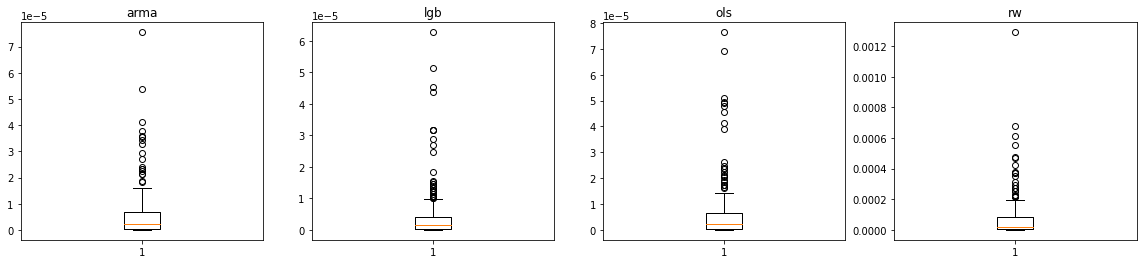

In [16]:
fig, ax = plt.subplots(ncols=len(model_list), nrows=1, figsize=(len(model_list) * 5, 4))

_df = df_f[[item for item in df_f.columns if "se" in item]].copy()
for i, item in enumerate(model_list):
    ax[i].boxplot(_df.iloc[:, i])
    ax[i].set_title(item.model_type)


In [17]:
import scipy.stats as stats

def _anova_assumptions(*args,
                       sig: float = .05):
    for item in args:
        assert (type(item) == pd.Series) | (type(item) == list) | (type(item) == np.array), 'args need to bo of type array'
    
    norm_res = []
    for item in args:
        norm = stats.normaltest(item)
        norm_res.append(norm)
    
    lev = stats.levene(*args)
    
    if lev.pvalue > sig:
        print("\nLevene's of variance homogenity")
        print(f"Samples have same variance: {lev.pvalue < sig}")
        print(f"Pvalue: {lev.pvalue}")
    
    for item, arr in zip(norm_res, args):
        if item.pvalue > sig:
            print("\nNormality test")
            print(f"Sample {arr.name} is normally distributed {item.pvalue < sig}")
            print(f"Pvalue: {item.pvalue}")
    
    return lev, norm_res    

def anova(*args,
          sig: float = .05,
         print_res: bool = True):
    _anova_assumptions(*args, sig=sig)
    res = stats.f_oneway(*args)
    
    is_sig = res.pvalue < sig
    
    if print_res:
        print('\nOne-way ANOVA')
        print(f'ANOVA test statistics: {res.statistic}')
        print(f'ANOVA pvalue: {res.pvalue}')
        print(f'Difference in means exists: {is_sig}')
    
    return is_sig

In [22]:
anova(df_f.arma_y_pred_se, df_f.lgb_y_pred_se, df_f.ols_y_pred_se)


Levene's of variance homogenity
Samples have same variance: False
Pvalue: 0.2041606726532124

One-way ANOVA
ANOVA test statistics: 2.033430354077288
ANOVA pvalue: 0.13164624585297996
Difference in means exists: False


False

In [20]:
sig = .05 / 3
print("Diebold-Marion Test")

print(f"ARMA: {dm_test(df_f.y_test, df_f.arma_y_pred, df_f.rw_y_pred).p_value < sig}")
print(f"OLS: {dm_test(df_f.y_test, df_f.ols_y_pred, df_f.rw_y_pred).p_value < sig}")
print(f"LGB: {dm_test(df_f.y_test, df_f.lgb_y_pred, df_f.rw_y_pred).p_value < sig}")

Diebold-Marion Test
ARMA: True
OLS: True
LGB: True
